In [2]:
import pandas as pd
from changeit3d.language.vocabulary import Vocabulary
from changeit3d.utils.visualization import visualize_src_trg_df_at_loc_i

%load_ext autoreload
%autoreload 2

In [3]:
top_img_dir = '../../data/shapetalk/images/full_size'
shapetalk_file = '../../data/shapetalk/language/shapetalk/shapetalk_preprocessed_public_version_0.csv'
vocab_file = '../../data/shapetalk/language/shapetalk/vocabulary.pkl'
out_save_csv_file = '../../data/shapetalk/misc/shapetalk_preprocessed_public_merged_utters_version_0.csv'

In [4]:
df = pd.read_csv(shapetalk_file)
print('Total collected entries/utterances', len(df))
vocab = Vocabulary.load(vocab_file)
print('Total kept vocabulary tokens', len(vocab))

Total collected entries/utterances 536596
Total kept vocabulary tokens 5883


In [5]:
print(vocab.special_symbols)
merging_symbol = vocab.dia # let's use a special symbol to signify that we are merging utterances
                           # here we will use <dia> which exists in the language.Vocabulary by default contruction                           
merging_symbol_string = " " + vocab.idx2word[merging_symbol] + " "

['<pad>', '<sos>', '<eos>', '<unk>', '<dia>']


In [6]:
# no need to keep those ('ignore') utterances in this view of the dataset
df = df[df.listening_split != 'ignore']
df.reset_index(inplace=True, drop=True)

In [7]:
# group the responses of a single user in a given distractor/target "context" 
g = df.groupby('assignmentid') 
print(len(g))

# aggregate spelled sentences
merged_df = []

for name, items in g:
    assert len(items.listening_split.unique()) == 1 
    assert len(set(items.changeit_split.unique()) - {'ignore'}) <= 1
        
    items = items.sort_values('saliency') # highest saliency first
    joint_utterance_spelled = merging_symbol_string.join(items['utterance_spelled'])
    joint_utterance = merging_symbol_string.join(items['utterance'])
    
    keep = items.iloc[0].copy()    
    keep['utterance_spelled'] = joint_utterance_spelled
    keep['utterance'] = joint_utterance
        
    if 'ignore' in items.changeit_split.unique():
        keep['changeit_split'] = 'ignore'
                
    merged_df.append(keep)

merged_df = pd.DataFrame(merged_df)
merged_df.reset_index(inplace=True, drop=True)

130296


In [8]:
# update statistics based on merged utterances
merged_df['tokens'] = merged_df.utterance_spelled.apply(lambda x: x.split())  
merged_df['tokens_len'] = merged_df.tokens.apply(lambda x: len(x))
merged_df['saliency'] = "all-merged"


max_len_for_merged = merged_df['tokens_len'].max()
print('max_len_for_merged', max_len_for_merged)
merged_df.tokens_encoded = merged_df.tokens.apply(lambda x: vocab.encode(x, max_len=max_len_for_merged))

# delete below non-sensible now
merged_df = merged_df.drop(columns=['is_patched'])

max_len_for_merged 76


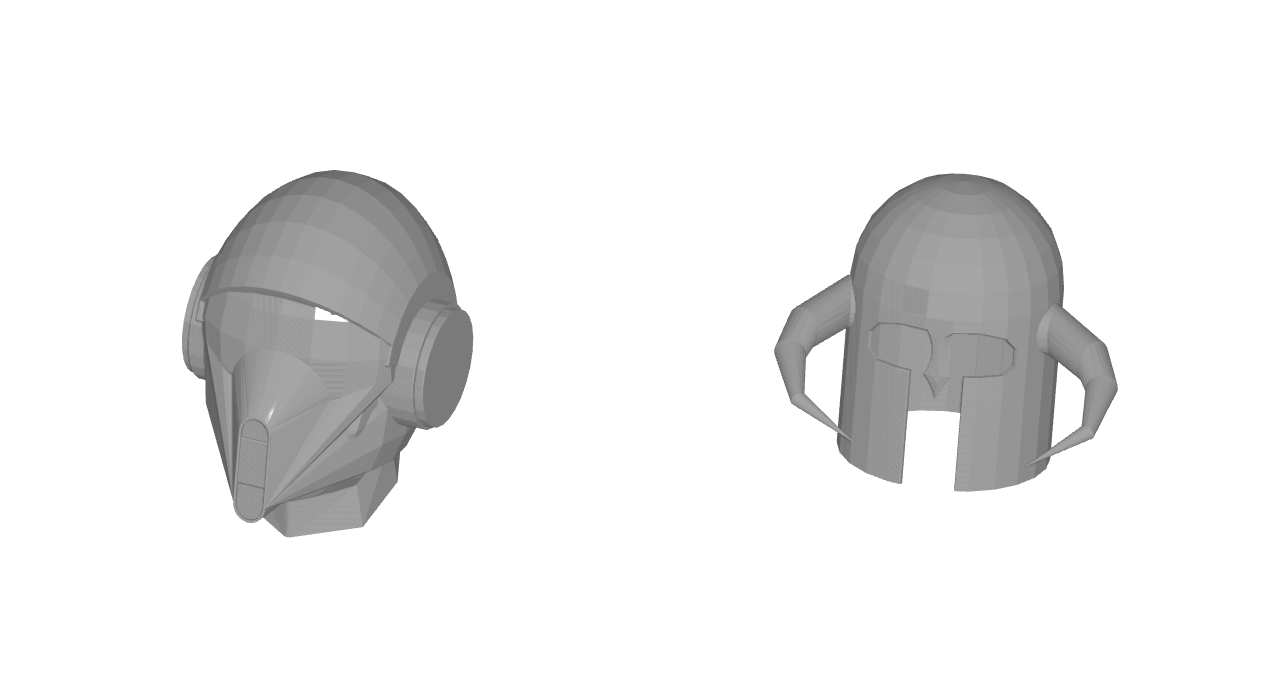

3A1COHJ8NLO3IO1TYYVSP6T62VC8HE
utteranceall-merged:
Original: It has horns coming out of the sides. <dia> The face has two round cut-out places for eyes. <dia> The face shield is not triangular and solid.
Spelled: it has horns coming out of the sides <dia> the face has two round cut out places for eyes <dia> the face shield is not triangular and solid


In [9]:
visualize_src_trg_df_at_loc_i(merged_df, merged_df.sample(1).index[0], top_img_dir=top_img_dir)

In [10]:
merged_df.to_csv(out_save_csv_file, index=False)

NameError: name 'out_save_csv_file' is not defined